# Fitting a linear mixed model and accessing the parameter estimates 

Below we demonstrate how to fit linear mixed models using the Ruby gem [mixed\_models](https://github.com/agisga/mixed_models). We also show how to access various parameters estimated by the linear mixed model, and we use them to assess the goodness of fit of the resulting model.

We will fit the model with the user friendly method `LMM#from_formula`, which mimics the behaviour of the function `lmer` from the `R` package `lme4`. The formula language used by `mixed_models` is in fact a subset of the `lme4` formula interface. It allows to fit all of the same models, but does not allow for cetain shortcuts, namely the symbols `*`, `||` and `/`. However, for all of these shortcuts longer alternative formulations exist in all cases (e.g. you need to use the equivalent formulation `a + b + a:b` instead of `a*b`). An expanation of the `lme4` formula interface can be found in the [`lme4` vignette](https://cran.r-project.org/web/packages/lme4/vignettes/lmer.pdf). Additionally, there is a multitude of posts on stackexchange ([such as this](http://stats.stackexchange.com/questions/13166/rs-lmer-cheat-sheet)) discussing the formula formulation in `lme4`. 


## Table of Contents

* Example data

* Linear mixed model

* Model attributes

* Fitted values and residuals

* Assessing the quality of the model fit

## Example data

The data set, which is simulated, contains two numeric variables *Age* and *Aggression*, and two categorical variables *Location* and *Species*. These data are available for 100 (human and alien) individuals.

The data is supplied to `LMM#from_formula` as a `Daru::DataFrame` (from the excellent Ruby gem [daru](https://github.com/v0dro/daru.git)). We load the data, and display the first 10 lines with:

In [1]:
require 'daru'
alien_species = Daru::DataFrame.from_csv '../examples/data/alien_species.csv'
alien_species.head

"if(window['d3'] === undefined ||\n   window['Nyaplot'] === undefined){\n    var path = {\"d3\":\"http://d3js.org/d3.v3.min\",\"downloadable\":\"http://cdn.rawgit.com/domitry/d3-downloadable/master/d3-downloadable\"};\n\n\n\n    var shim = {\"d3\":{\"exports\":\"d3\"},\"downloadable\":{\"exports\":\"downloadable\"}};\n\n    require.config({paths: path, shim:shim});\n\n\nrequire(['d3'], function(d3){window['d3']=d3;console.log('finished loading d3');require(['downloadable'], function(downloadable){window['downloadable']=downloadable;console.log('finished loading downloadable');\n\n\tvar script = d3.select(\"head\")\n\t    .append(\"script\")\n\t    .attr(\"src\", \"http://cdn.rawgit.com/domitry/Nyaplotjs/master/release/nyaplot.js\")\n\t    .attr(\"async\", true);\n\n\tscript[0][0].onload = script[0][0].onreadystatechange = function(){\n\n\n\t    var event = document.createEvent(\"HTMLEvents\");\n\t    event.initEvent(\"load_nyaplot\",false,false);\n\t    window.dispatchEvent(event);\n\t

,Age,Aggression,Location,Species
0,204.95,877.54242028595,Asylum,Dalek
1,39.88,852.528392188206,OodSphere,WeepingAngel
2,107.34,388.791416909388,Asylum,Human
3,210.01,170.010124622982,OodSphere,Ood
4,270.22,1078.31219494376,OodSphere,Dalek
5,157.65,164.924992952256,OodSphere,Ood
6,136.15,865.838374677443,OodSphere,WeepingAngel
7,241.31,1052.36035549029,Earth,Dalek
8,86.84,-8.57251993382567,Asylum,Ood
9,206.7,1070.71900405899,OodSphere,Dalek


## Linear mixed model

We model the *Aggression* level of an individual as a linear function of the *Age* (*Aggression* decreases with *Age*), with a different constant added for each *Species* (i.e. each species has a different base level of aggression). Moreover, we assume that there is a random fluctuation in *Aggression* due to the *Location* that an individual is at. Additionally, there is a random fluctuation in how *Age* affects *Aggression* at each different *Location*. 

Thus, the *Aggression* level of an individual of *Species* $spcs$ who is at the *Location* $lctn$ can be expressed as:
$$Aggression = \beta_{0} + \gamma_{spcs} + Age \cdot \beta_{1} + b_{lctn,0} + Age \cdot b_{lctn,1} + \epsilon,$$
where $\epsilon$ is a random residual, and the random vector $(b_{lctn,0}, b_{lctn,1})^T$ follows a multivariate normal distribution (the same distribution but different realizations of the random vector for each *Location*). That is, we have a linear mixed model with fixed effects $\beta_{0}, \beta_{1}, \gamma_{Dalek}, \gamma_{Ood}, \dots$, and random effects $b_{Asylum,0}, b_{Asylum,1}, b_{Earth,0},\dots$.

We fit this model in `mixed_models` using a syntax familiar from the `R` package `lme4` (as described above), and display the estimated fixed and random effects coefficients:

In [2]:
require 'mixed_models'
model_fit = LMM.from_formula(formula: "Aggression ~ Age + Species + (Age | Location)", 
                             data: alien_species)
puts "Fixed effects:"
puts model_fit.fix_ef
puts "Random effects:"
puts model_fit.ran_ef

Fixed effects:
{:intercept=>1016.2867207696772, :Age=>-0.06531615343467667, :Species_lvl_Human=>-499.693695290209, :Species_lvl_Ood=>-899.5693213535769, :Species_lvl_WeepingAngel=>-199.58895804200762}
Random effects:
{:intercept_Asylum=>-116.68080682806675, :Age_Asylum=>-0.03353391213062394, :intercept_Earth=>83.86571630094429, :Age_Earth=>-0.13613996644462312, :intercept_OodSphere=>32.81508992422805, :Age_OodSphere=>0.16967387859838903}


A summary of the most important information about the fixed and random effects of the model can be conveniently displayed with the methods `LMM#fix_ef_summary` and `LMM#ran_ef_summary`.

`LMM#fix_ef_summary` contains the fixed effects coefficient estimates, the standard deviations of the estimates, as well as the corresponding z scores and Wald Z p-values testing the significance of each fixed effects term.

In [3]:
model_fit.fix_ef_summary

,coef,sd,z_score,WaldZ_p_value
intercept,1016.2867207696772,60.19727495932258,16.882603431075875,0.0
Age,-0.06531615343467667,0.08988486367253856,-0.7266646548258817,0.4674314106158888
Species_lvl_Human,-499.693695290209,0.2682523406941927,-1862.7747813759402,0.0
Species_lvl_Ood,-899.5693213535769,0.2814470814004366,-3196.2289922406044,0.0
Species_lvl_WeepingAngel,-199.58895804200762,0.2757835779525997,-723.7158917283754,0.0


`LMM#ran_ef_summary` summarizes the correlation structure of the random effects terms, that is, the correlation matrix of the vector $(b_{lctn,0}, b_{lctn,1})^T$ in the present data analysis.

In [4]:
model_fit.ran_ef_summary

,Location,Location_Age
Location,104.26376362946598,-0.059863903781248555
Location_Age,-0.059863903781248555,0.15567077553868952


In particular, we see that the standard deviation of the constant term corresponding to the variable *Location* is rather big (104.26...), and therefore *Location* must contribute hugely to the variance in *Aggression*. The variability of the effect of *Age* with respect to *Location*, however, seems rather small (0.15567...) in comparison.

## Model attributes

Apart from the fixed and random effects coefficients (seen above), we can access many attributes of the fitted model. Among others:

* `fix_ef_names` and `ran_ef_names` are Arrays of names of the fixed and random effects.

* `reml` is an indicator whether the profiled REML criterion or the profiled deviance function was optimized by the model fitting algorithm.

* `formula` returns the R-like formula used to fit the model as a String.

* `model_data`, `optimization_result` and `dev_fun` store the various model matrices in an `LMMData` object, the results of the utilized optimization algorithm, and the corresponding objective function as a `Proc`.

* `sigma2` is the residual variance (unless `weights` was specified in the model fit).

* `sigma_mat` is the covariance matrix of the multivariate normal random effects vector.

We can look at some of these parameters for our example model:

In [5]:
puts "REML criterion used: \t#{model_fit.reml}"
puts "Residual variance: \t#{model_fit.sigma2}"
puts "Formula: \t" + model_fit.formula
puts "Variance of the intercept due to 'location' (i.e. variance of b0): \t#{model_fit.sigma_mat[0,0]}"
puts "Variance of the effect of 'age' due to 'location' (i.e. variance of b1): \t#{model_fit.sigma_mat[1,1]}"
puts "Covariance of b0 and b1: \t#{model_fit.sigma_mat[0,1]}"

REML criterion used: 	true
Residual variance: 	0.9496833447256808
Formula: 	Aggression ~ Age + Species + (Age | Location)
Variance of the intercept due to 'location' (i.e. variance of b0): 	10870.932406181153
Variance of the effect of 'age' due to 'location' (i.e. variance of b1): 	0.024233390356817052
Covariance of b0 and b1: 	-0.9716403033290782


Some further convenience methods are (apart from `#fix_ef_summary` and `#ran_ef_summary` as seen above):

* `#sigma` returns the square root of `sigma2`.

* `#theta` returns the optimal solution of the minimization of the deviance function or the REML criterion (whichever was used to fit the model).

* `#deviance` returns  the value of the deviance function or the REML criterion at the optimal solution.

* `#ran_ef_cov` is a version of `#ran_ef_summary` that returns the covariance structure of the random effects rather than the correlation structure.


In [6]:
puts "Residual standard deviation: \t#{model_fit.sigma}"
puts "REML criterion: \t#{model_fit.deviance}"

Residual standard deviation: 	0.9745169802141371
REML criterion: 	333.715539101513


## Fitted values and residual

There are methods to get the fitted (i.e. predicted) values of the response variable, with or without inclusion of random effects, as well as the model residuals (which are differences between the true and the predicted values).

In [7]:
puts "Fitted values at the population level:"
model_fit.fitted(with_ran_ef: false)

Fitted values at the population level:


[1002.9001751232403, 814.0929545286947, 509.58198956979004, 103.00035403328388, 998.6369897885589, 106.42030782712357, 807.8049684375385, 1000.5252797843553, 111.04534465183303, 1002.7858718547295, 1008.0797460906101, 498.79959896079356, 100.90435866956511, 111.03358774421474, 102.37593160644838, 812.6239942379489, 97.21856813124623, 800.9297901270043, 510.0032787594437, 502.69505435163774, 503.7329280297147, 999.8864878037642, 497.2875300087809, 1003.3325680589778, 804.1328942914408, 811.9113950039764, 99.91285946042672, 803.9356395080681, 998.4671677896288, 99.50267401685687, 500.71140277182656, 1014.3853675431938, 112.41241174322079, 1010.3031079535265, 114.52212349916078, 813.8107887458568, 811.7526767511301, 498.69901208450415, 1005.0836941325615, 110.67826786953015, 501.0020596546109, 810.6305452351226, 511.31809292808373, 1000.7623774213233, 508.8465296821156, 1008.3730156195318, 1011.249539016795, 102.45953628284474, 1010.9490847109954, 1007.0346876356552, 506.2286582524538, 50

In [8]:
puts "Model residuals:"
model_fit.residuals

Model residuals:


[-1.8041727180520866, -1.1462465432205136, -0.5102357042341055, -1.4385305789776055, 1.010839756116411, -1.0594917601316638, 2.1172177445057514, 0.8212947077422541, -0.024972828168568384, 0.046451573745571295, -0.25215128087575067, 0.5337610637693615, -0.530629854101111, -0.874628273213915, -0.5173146938876982, -1.0767035113831298, -0.37352823345418074, 0.43428801048560217, -0.008686417241960953, 0.9633162152579189, -1.8591988675071889, -0.06035456182212329, -0.8747549066539477, 2.156663624529642, -0.12014582672793495, 1.5012618544112684, 0.5916114379899646, -1.4808531218287726, -0.16478112799109113, 2.0314537895965294, 0.010773844424193157, 0.8539551421492888, -1.2568149547066971, 0.07403493882111434, -0.11003692957027056, 1.0271335859753208, 1.289389380032162, -0.1484680679627104, -0.4342951733153768, 1.7157974749034395, 1.0173666823257577, -0.6984875406659512, 0.16845508494225214, -1.4232161610595995, -0.14893911781359748, 0.1337897922234106, -0.2102464993108697, 0.4063849522508747,

## Assessing the quality of the model fit

We can assess the goodness of the model fit (to some extent) by plotting the residuals agains the fitted values, and checking for unexpected patterns. We use the gem [gnuplotrb](https://github.com/dilcom/gnuplotrb) for plotting.

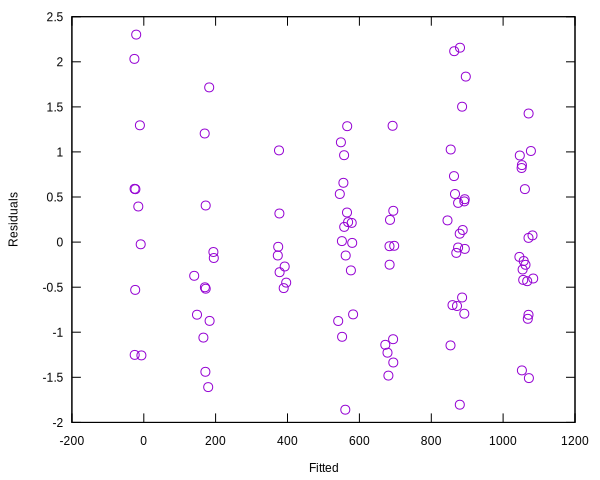

In [9]:
require 'gnuplotrb'
include GnuplotRB

x, y = model_fit.fitted, model_fit.residuals
fitted_vs_residuals = Plot.new([[x,y], with: 'points', pointtype: 6, notitle: true],
                               xlabel: 'Fitted', ylabel: 'Residuals')

We see that the residuals look more or less like noise, which is good.

We can further analyze the validity of the linear mixed model somewhat, by checking if the residuals appear to be approximately normally distributed.

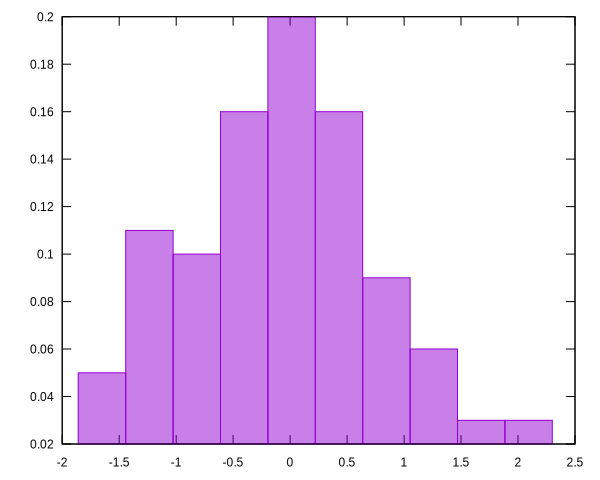

In [10]:
bin_width = (y.max - y.min)/10.0
bins = (y.min..y.max).step(bin_width).to_a
rel_freq = Array.new(bins.length-1){0.0}
y.each do |r|
  0.upto(bins.length-2) do |i|
    if r >= bins[i] && r < bins[i+1] then
      rel_freq[i] += 1.0/y.length
    end
  end
end
bins_center = bins[0...-1].map { |b| b + bin_width/2.0 }
  
residuals_hist = Plot.new([[bins_center, rel_freq], with: 'boxes', notitle: true],
                           style: 'fill solid 0.5')

The histogram does not appear to be too different from a bell shaped curve, although it might be slightly skewed to the right.

We can further explore the validity of the normality assumption by looking at the Q-Q plot of the residuals.

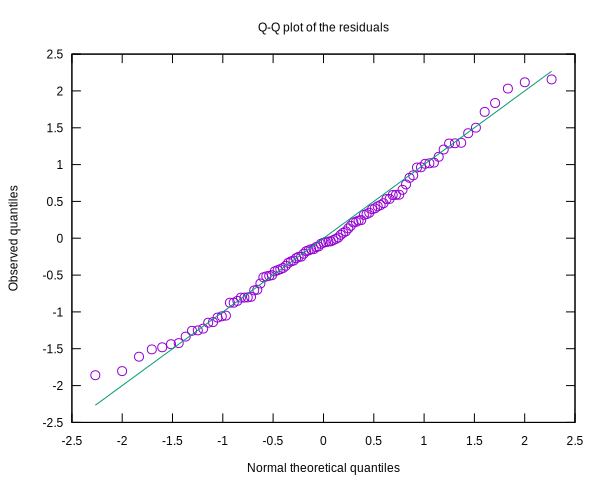

In [11]:
require 'distribution'

observed = model_fit.residuals.sort
n = observed.length
theoretical = (1..n).to_a.map { |t| Distribution::Normal.p_value(t.to_f/n.to_f) * model_fit.sigma}
qq_plot = Plot.new([[theoretical, observed], with: 'points', pointtype: 6, notitle: true],
                   ['x', with: 'lines', notitle: true],
                   xlabel: 'Normal theoretical quantiles', ylabel: 'Observed quantiles',
                   title: 'Q-Q plot of the residuals')

The straight line in the above plot is simply the diagonal. We see that the observed quantiles aggree with the theoretical values fairly well, as expected from a "good" model.